# Caterpillar Tube Pricing

## Project 1 - Visualization and Data Preprocessing
### Team Members:
1. Harry Bhasin
2. Oscar Padilla
3. Najeeb Zaidi

Model quoted prices for industrial tube assemblies

Source: Kaggle

https://www.kaggle.com/c/caterpillar-tube-pricing

21 files provided
3 files merged using SQL: train_set, specs, tube

Data Set Description
Caterpillar builds large earth moving machines for constructions and mining. Each machine comprises of several smaller componenents including tubes to help keep the moving parts moving. There are two tube assemblies that come in a number of dimentions with several base materials, number of bends, bend radius, bolt patterns, and end types. Our team decided to use tubing data set for this project, predicting the price a supplier will quote for a given assembly.


The goal from the following section is to interrogate various contributing factors in the assembly, the structure/bend/dimension factor of each tube, sub components, vendor, and the pricing per quantity. The result of this section will produce a single data set with relevant attributes both continuous and categorical.
In an effort to create a single data set from several different data files SQL was used to do a join before further formatting the data. The outcome is a single data set consisting of approximately 30K records with 32 columns. This columns with different variable names are described below.


tube_assembly_id: This variable is to identify the tube.

supplier: This variable holds the vendor's identification number.

quote_date: This variable has the date of the quote. The formatting was done to this variable.

annual_usage: This variable is tied to the date of the quote and stores the usage.

min_order_quantity: This variable is tied to the price as the quantity is used for pricing.

bracket_pricing: This variable holds the pricing with or without bracket.

quantity: The cost is given assuming purchase of quantity of tubes.

cost tube_assembly: This variable holds the price based on the quantity ordered.

spec1 - spec10: These variables hold the unique specifications with respective codes for the tube assembly.

material_id: This variable holds the code for the material.

diameter: This variable holds the diameter of the ordered tube.

wall: This variable holds the thickness of the tube wall.

length: This variable holds the length of the tube.

num_bends: The variable holds the number of bends in a given tube assembly.

bend_radius: This varibale holds the radius of the respected bend.

end_a_1x, end_a_2x, end_x_1x, end_x_2x, end_a, end_x: These variables hold the code for the shape of different ends of the tube.

num_boss: This variable holds the quantity of boss.

num_bracket: This variable holds the number of brackets in a given tube.

Tube Assemblies are made of multiple parts. The main piece is the tube which has a specific diameter, wall thickness, length, number of bends and bend radius. Either end of the tube (End A or End X) typically has some form of end connection allowing the tube assembly to attach to other features. Special tooling is typically required for short end straight lengths (end_a_1x, end_a_2x refer to if the end length is less than 1 times or 2 times the tube diameter, respectively). Other components can be permanently attached to a tube such as bosses, brackets or other custom features.

Prices can be quoted in 2 ways: bracket and non-bracket pricing. Bracket pricing has multiple levels of purchase based on quantity (in other words, the cost is given assuming a purchase of quantity tubes). Non-bracket pricing has a minimum order amount (min_order) for which the price would apply. Each quote is issued with an annual_usage, an estimate of how many tube assemblies will be purchased in a given year.


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

# import consolidated file

df = pd.read_csv('/Users/GS7271/Documents/MSDS7331/Project/train_set.csv')

# eliminate redundant primary keys leftover from SQL merge

del df['tube_assembly']
del df['tube_assembly.1']
del df['spec10']

# convert variables to the right type

df['quote_date'] = pd.to_datetime(df['quote_date'],format="%Y-%m-%d")

df = df.replace("Y", 1)
df = df.replace("N", 0)
df = df.replace("Yes", 1)
df = df.replace("No", 0)

df['bracket_pricing']=df['bracket_pricing'].astype('bool')
df['end_a_1x']=df['end_a_1x'].astype('bool')
df['end_a_2x']=df['end_a_2x'].astype('bool')
df['end_x_1x']=df['end_x_1x'].astype('bool')
df['end_x_2x']=df['end_x_2x'].astype('bool')

# group variables per type

continuous_features = ['cost', 'diameter', 'wall', 'length', 'bend_radius']
categ_features = ['tube_assembly_id', 'supplier', 'spec1', 'spec2', 'spec3', 'spec4', 'spec5', 'spec6', 'spec7', 'spec8', 'spec9', 'material_id','end_a', 'end_x']
boolean_features = ['bracket_pricing','end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x']
integer_features = ['annual_usage', 'quantity', 'min_order_quantity', 'num_bends', 'num_boss', 'num_bracket', 'other']

df[integer_features] = df[integer_features].astype(np.int64)

print(df.info())
df.dtypes
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30213 entries, 0 to 30212
Data columns (total 32 columns):
tube_assembly_id      30213 non-null object
supplier              30213 non-null object
quote_date            30213 non-null datetime64[ns]
annual_usage          30213 non-null int64
min_order_quantity    30213 non-null int64
bracket_pricing       30213 non-null bool
quantity              30213 non-null int64
cost                  30213 non-null float64
spec1                 5797 non-null object
spec2                 5551 non-null object
spec3                 4650 non-null object
spec4                 3336 non-null object
spec5                 2312 non-null object
spec6                 1687 non-null object
spec7                 306 non-null object
spec8                 56 non-null object
spec9                 4 non-null object
material_id           29984 non-null object
diameter              30213 non-null float64
wall                  30213 non-null float64
length              

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,spec1,spec2,...,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
30208,TA-21190,S-0041,2013-09-10,869,75,False,75,5.945260,NaN,NaN,...,31.75,False,False,False,False,EF-003,EF-018,0,0,0
30209,TA-21191,S-0041,2013-09-10,752,1,False,1,6.131658,SP-0007,SP-0024,...,31.75,False,False,False,False,EF-003,EF-018,0,0,0
30210,TA-21195,S-0041,2013-08-05,1,80,False,80,5.066130,NaN,NaN,...,38.10,False,False,False,False,EF-003,EF-009,0,0,0
30211,TA-21196,S-0062,2005-05-09,422,1,False,1,18.214141,SP-0007,SP-0080,...,50.80,True,True,False,False,EF-003,EF-017,0,0,0
30212,TA-21197,S-0026,2009-07-30,3,1,False,1,53.618624,SP-0007,SP-0080,...,50.80,True,True,False,False,EF-003,EF-017,0,0,0


In [2]:
df.describe()

,annual_usage,min_order_quantity,quantity,cost,diameter,wall,length,num_bends,bend_radius,num_boss,num_bracket,other
count,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000
mean,120.369377,2.084699,38.389369,13.433317,17.223018,1.384782,97.647605,3.813061,42.231223,0.025254,0.003542,0.013603
std,1590.331872,12.742776,70.761392,28.663200,18.125973,0.638610,63.230131,2.199564,200.313458,0.184975,0.069664,0.150840
min,0.000000,0.000000,1.000000,0.503553,3.180000,0.710000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,3.878190,9.520000,0.890000,48.000000,2.000000,19.050000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,10.000000,6.521146,12.700000,1.240000,86.000000,3.000000,31.750000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,40.000000,13.431781,19.050000,1.650000,133.000000,5.000000,50.800000,0.000000,0.000000,0.000000
max,150000.000000,535.000000,2500.000000,1000.000000,203.200000,7.900000,1333.000000,17.000000,9999.000000,5.000000,3.000000,8.000000


### Interactive Chart

Interactive chart that shows cost behavior by quantity

Enter Tube Assembly ID: TA-08034


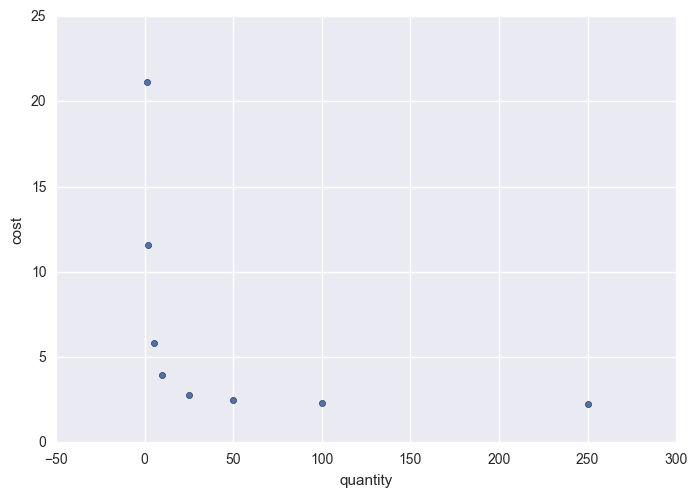

In [5]:
input_tube_assembly = raw_input('Enter Tube Assembly ID: ')

df[df.tube_assembly_id == input_tube_assembly].plot.scatter(x = 'quantity', y = 'cost')

### Curve fitting 

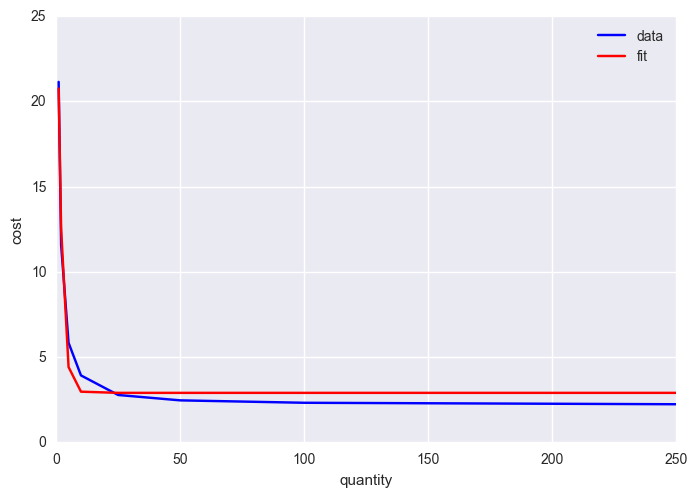

In [6]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

xdata = df[df.tube_assembly_id == input_tube_assembly].quantity
ydata = df[df.tube_assembly_id == input_tube_assembly].cost
popt, pcov = curve_fit(func, xdata, ydata)
plt.plot(xdata, ydata, 'b-', label='data')
plt.plot(xdata, func(xdata, *popt), 'r-', label='fit')
plt.xlabel('quantity')
plt.ylabel('cost')
plt.legend()
plt.show()

### Elimination of outliers

In [53]:
# Length cannot be zero
df_new = df[df.length > 0]
# Bend radius cannot be greater than 360 degrees
df_new = df[df.bend_radius <= 360]

### Log Transformation - Cost has a funnel shape

In [54]:
df_new["logcost"] = np.log(df_new["cost"])

/Users/GS7271/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Sin Transformation - Bend Radius

/Users/GS7271/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


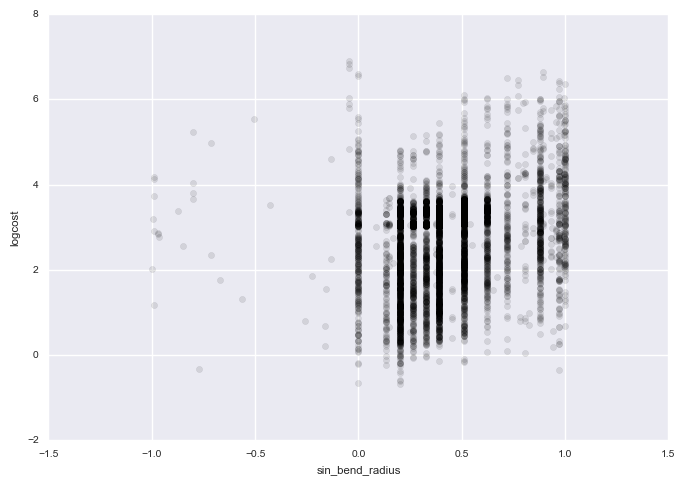

In [55]:
df_new["sin_bend_radius"] = np.sin(df_new["bend_radius"])
ax = df_new[df_new.quantity == 1].plot.scatter(x = 'sin_bend_radius', y = 'logcost', c='k', alpha = 0.1)

### Creation of a New Variable: Volume = *f(wall thickness, diameter, length)*

$$Volume = \pi (wall^2 + diameter \times wall) length$$

In [61]:
df_new = df_new[df_new.length > 0]

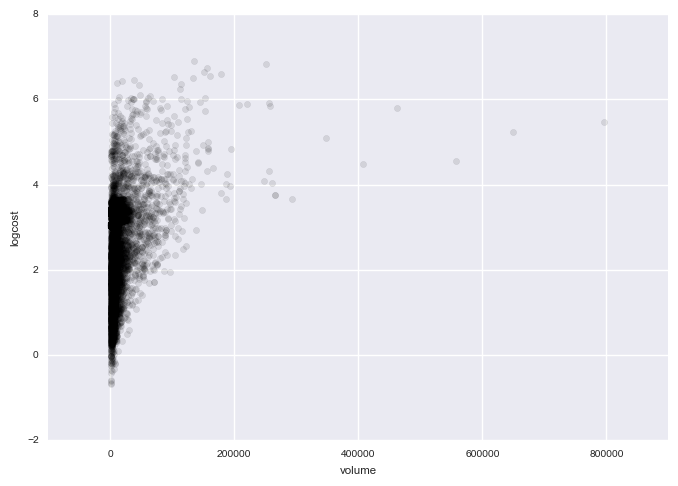

In [63]:
import math
df_new["volume"] = math.pi*(pow((df_new["wall"]), 2) + (df_new["wall"]*df_new["diameter"]))*(df_new["length"])
ax = df_new[df_new.quantity == 1].plot.scatter(x = 'volume', y = 'logcost', c='k', alpha = 0.1)

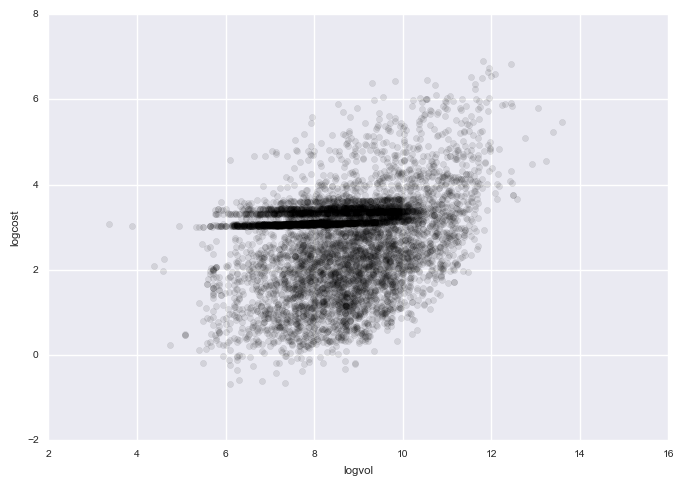

In [64]:
df_new["logvol"] = np.log(df_new["volume"])
ax = df_new[df_new.quantity == 1].plot.scatter(x = 'logvol', y = 'logcost', c='k', alpha = 0.1)

In [85]:
# Verify that no observations have volume = 0 thus creating an error on the log transformation
df_new.tube_assembly_id[df_new["volume"] == 0]

Series([], Name: tube_assembly_id, dtype: object)

### Log Transformation - Annual Usage

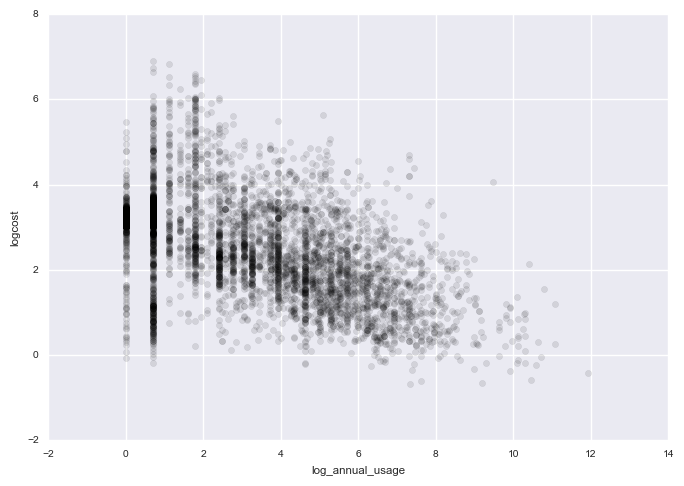

In [75]:
df_new["log_annual_usage"] = np.log(df_new["annual_usage"] + 1)
ax = df_new[df_new.quantity == 1].plot.scatter(x = 'log_annual_usage', y = 'logcost', c='k', alpha = 0.1)

### Log Transformation - Min Order Quantity 

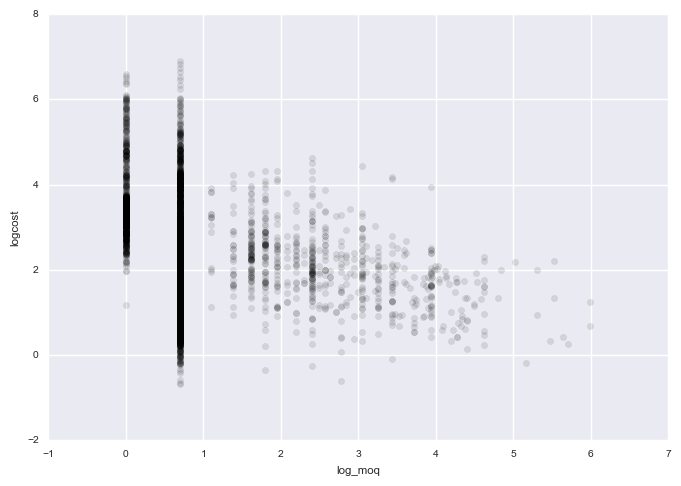

In [76]:
df_new["log_moq"] = np.log(df_new["min_order_quantity"] + 1)
ax = df_new[df_new.quantity == 1].plot.scatter(x = 'log_moq', y = 'logcost', c='k', alpha = 0.1)

### Boxplots of Categorical and Integer Variables

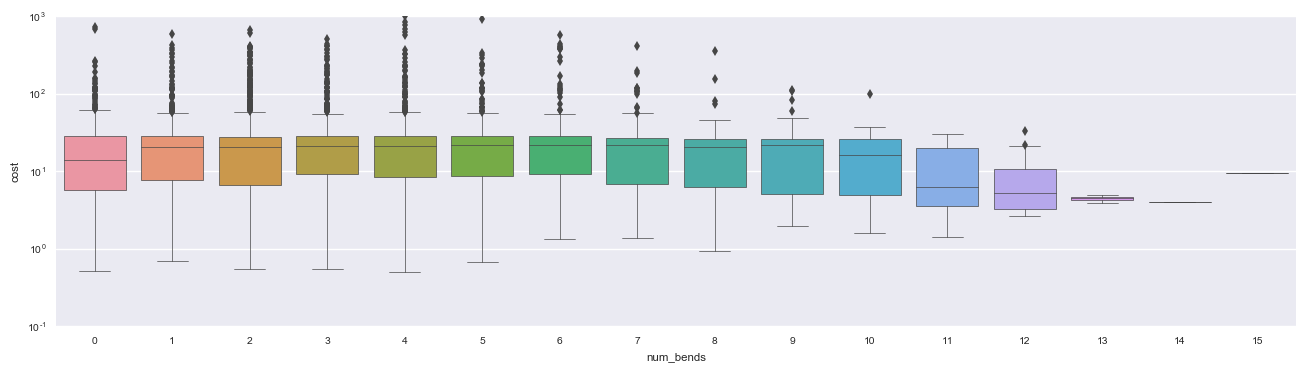

In [67]:
plt.figure(figsize = (16, 4))
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=0.75, rc={"lines.linewidth": 0.5})
ax = sns.boxplot(x = "num_bends", y = "cost", data = df_new[df_new.quantity == 1])
sns.despine(left = True)
ax.set_yscale('log')

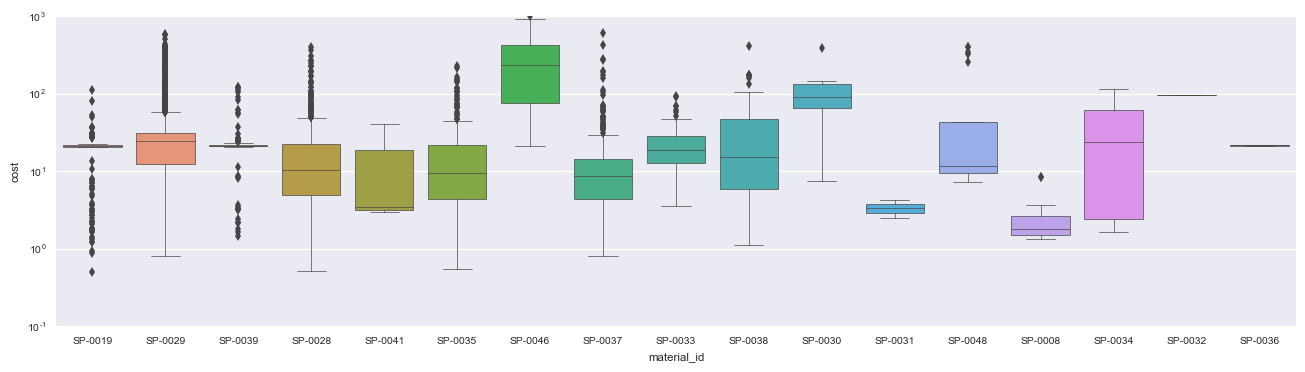

In [68]:
plt.figure(figsize = (16, 4))
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=0.75, rc={"lines.linewidth": 0.5})
ax = sns.boxplot(x = "material_id", y = "cost", data = df_new[df_new.quantity == 1])
sns.despine(left = True)
ax.set_yscale('log')

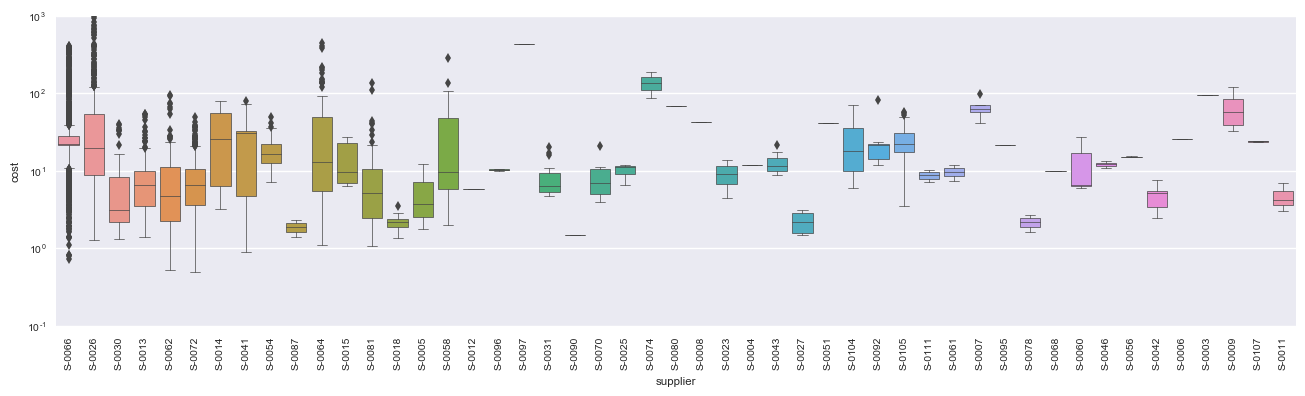

In [69]:
plt.figure(figsize = (16, 4))
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=0.75, rc={"lines.linewidth": 0.5})
ax = sns.boxplot(x = "supplier", y = "cost", data = df_new[df_new.quantity == 1])
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
sns.despine(left = True)
ax.set_yscale('log')

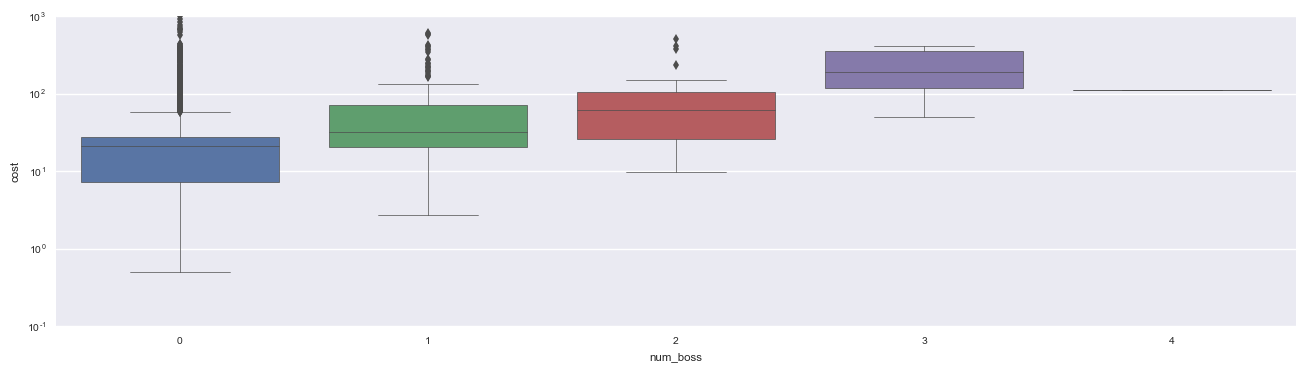

In [70]:
plt.figure(figsize = (16, 4))
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=0.75, rc={"lines.linewidth": 0.5})
ax = sns.boxplot(x = "num_boss", y = "cost", data = df_new[df_new.quantity == 1])
sns.despine(left = True)
ax.set_yscale('log')

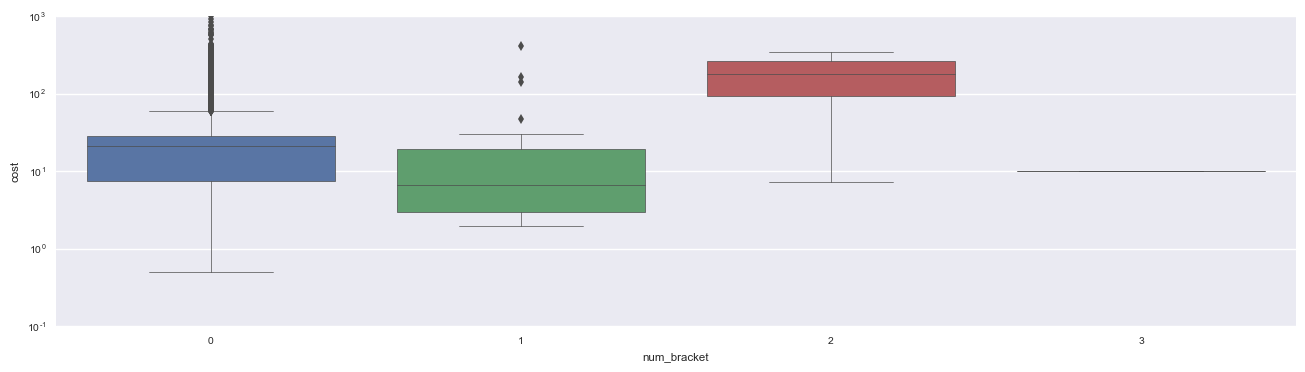

In [71]:
plt.figure(figsize = (16, 4))
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=0.75, rc={"lines.linewidth": 0.5})
ax = sns.boxplot(x = "num_bracket", y = "cost", data = df_new[df_new.quantity == 1])
sns.despine(left = True)
ax.set_yscale('log')

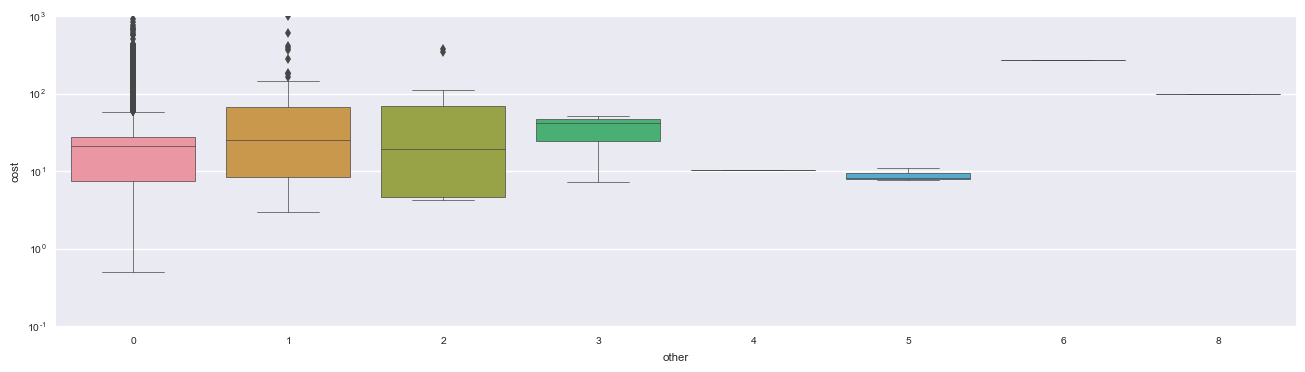

In [72]:
plt.figure(figsize = (16, 4))
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=0.75, rc={"lines.linewidth": 0.5})
ax = sns.boxplot(x = "other", y = "cost", data = df_new[df_new.quantity == 1])
sns.despine(left = True)
ax.set_yscale('log')

### Distribution of Quotes by Year

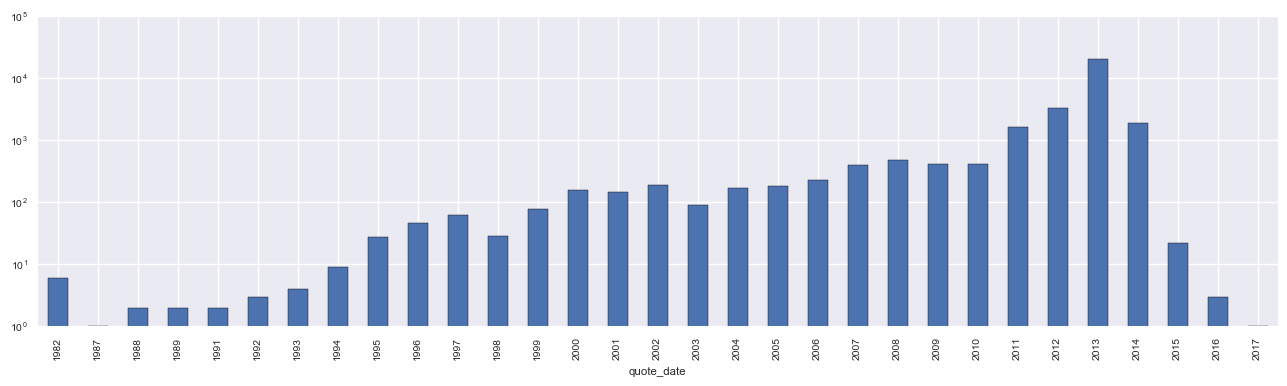

In [73]:
plt.figure(figsize = (16, 4))
ax = df.groupby(df["quote_date"].dt.year)["quote_date"].count().plot(kind="bar")
ax.set_yscale('log')

### Histogram of Quoted Quantities

(array([    0.,  7054.,  3513.,  4300.,  4870.,  2972.,  2725.,  2454.,
         2256.,    23.]),
 array([   0,    1,    2,    5,   10,   25,   50,  100,  250,  500, 2500]),
 <a list of 10 Patch objects>)

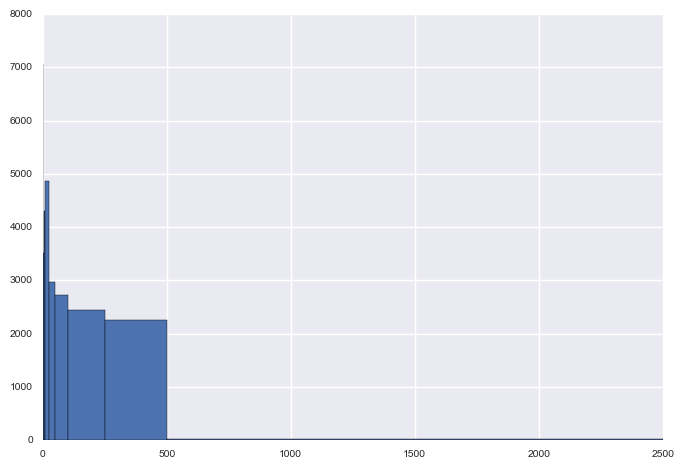

In [146]:
plt.hist(df_new.quantity, bins = [0, 1, 2, 5, 10, 25, 50, 100, 250, 500, 2500])

### Log Cost as a function of Log Vol by Material
#### matplotlib.pyplot

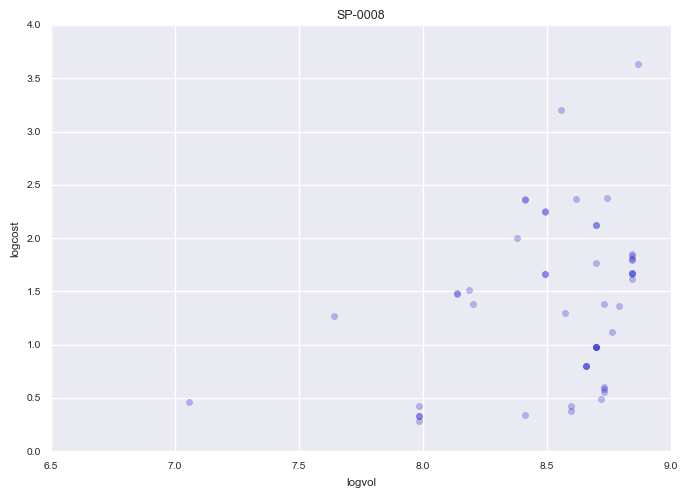

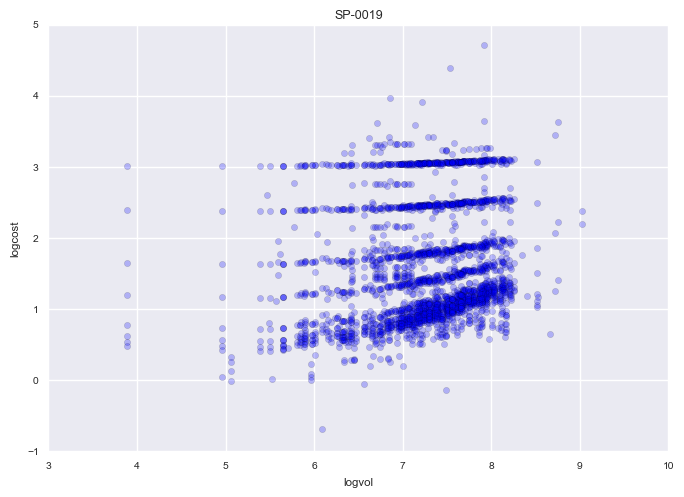

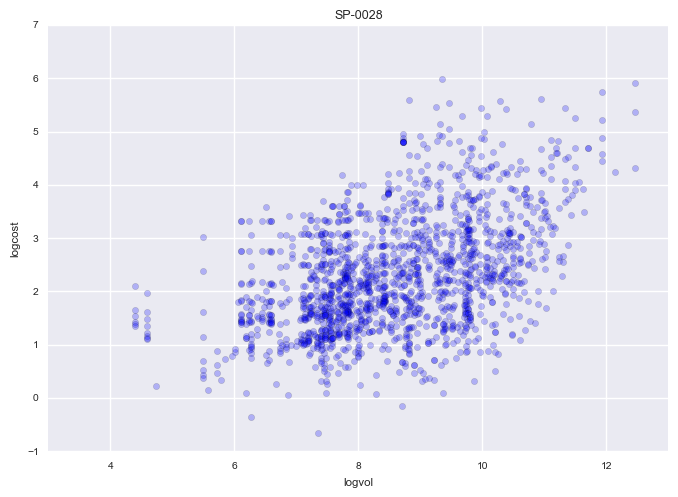

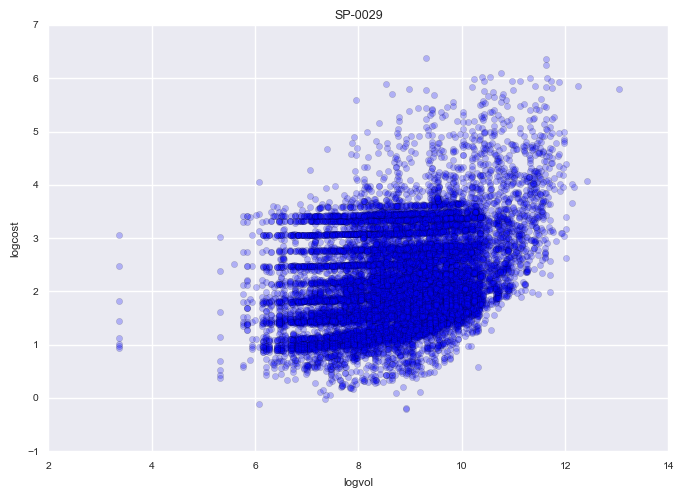

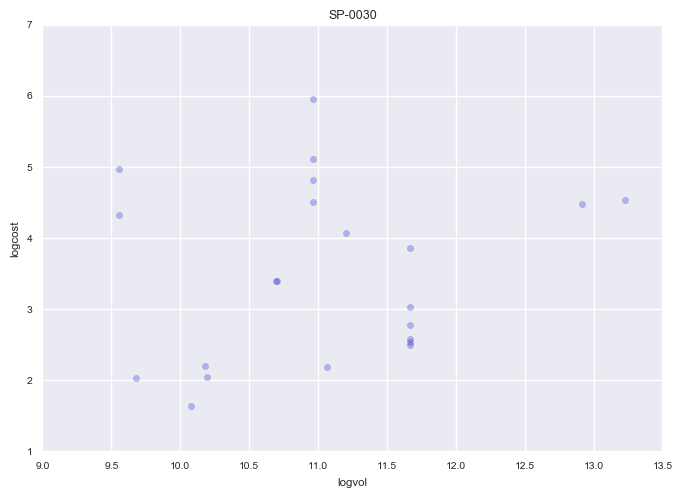

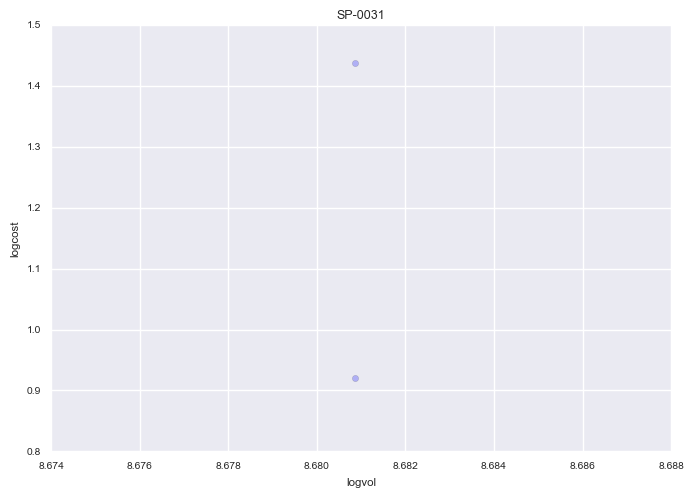

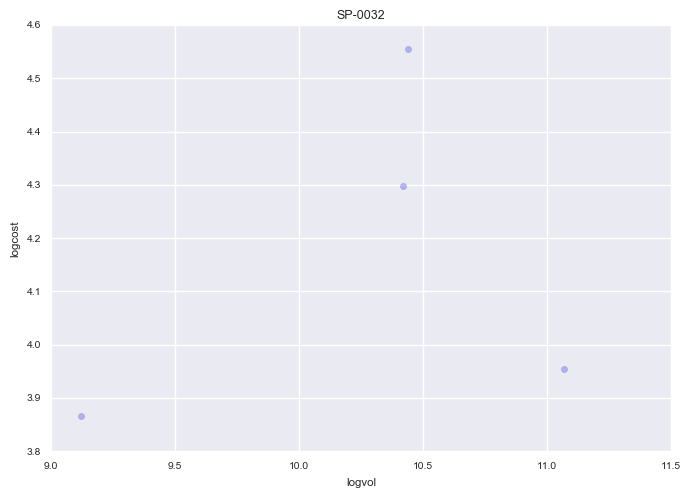

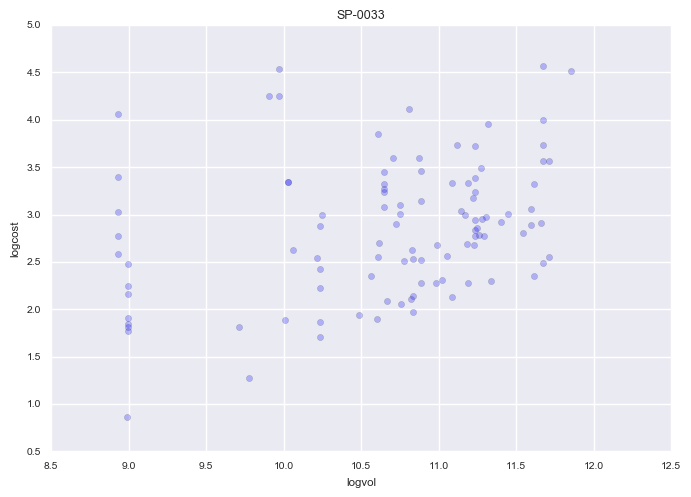

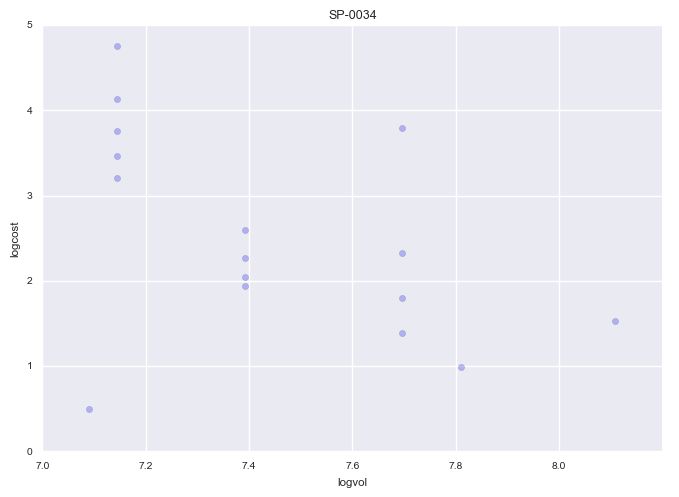

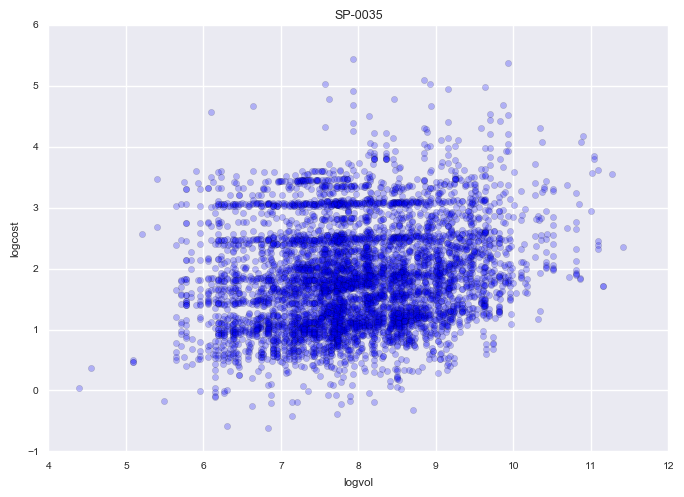

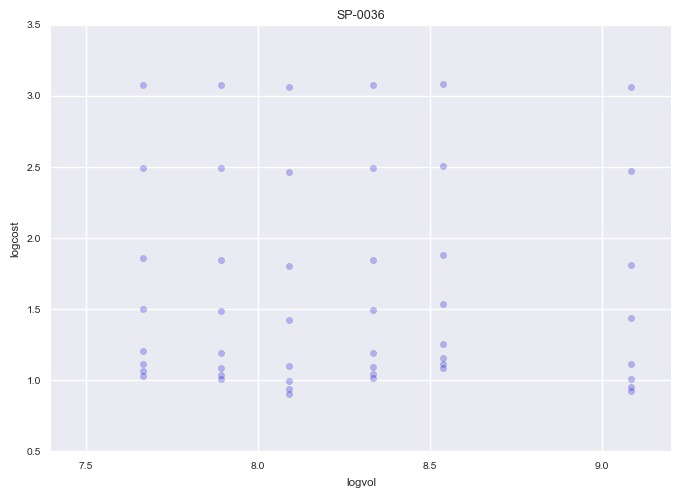

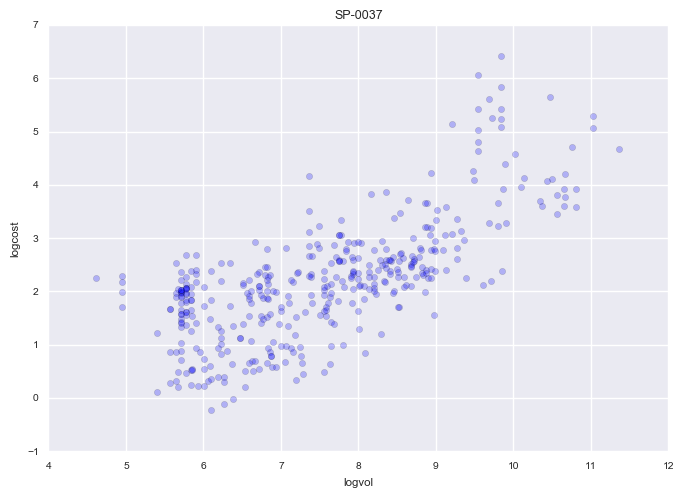

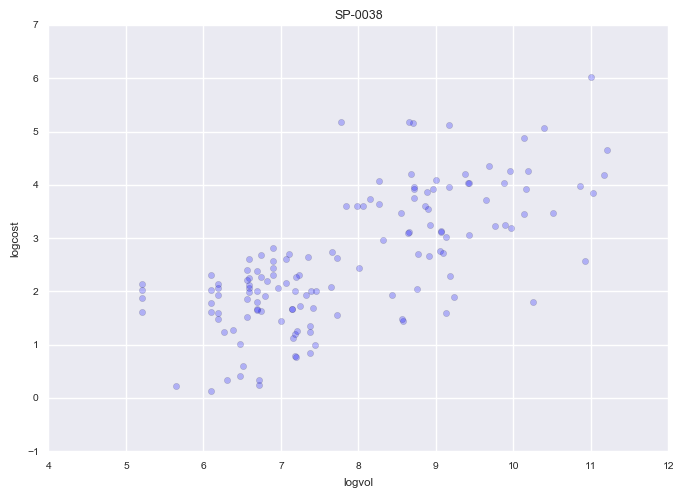

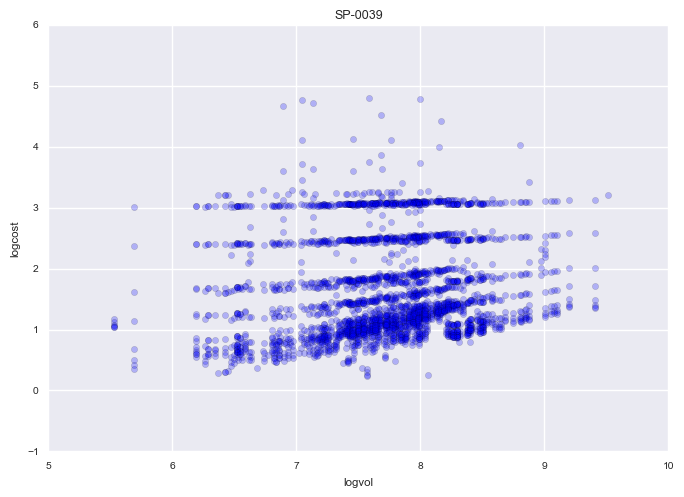

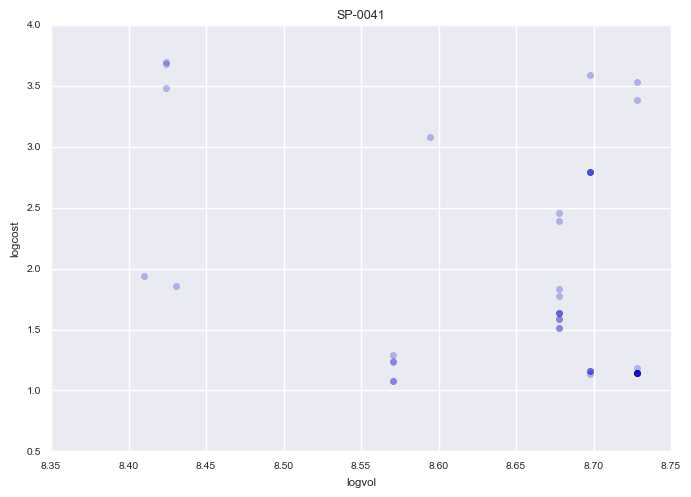

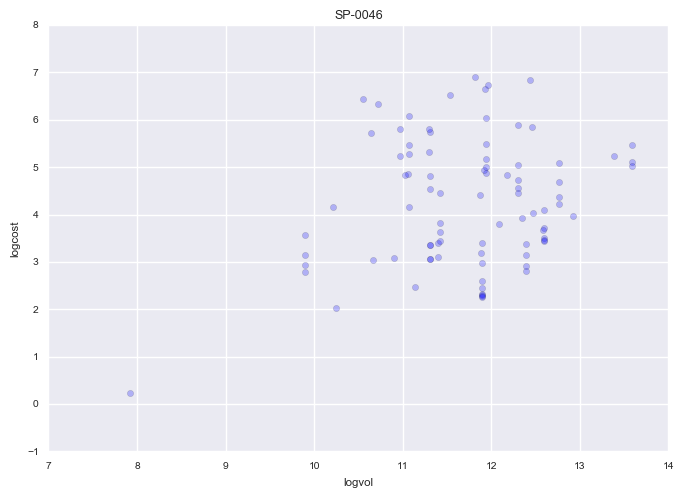

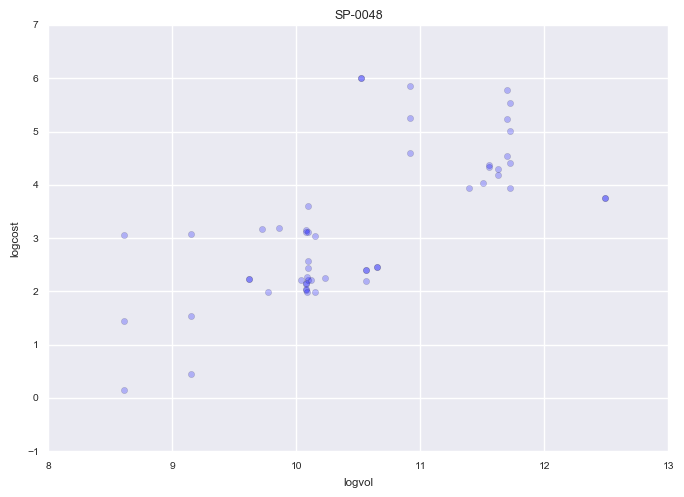

In [135]:
material_list = list(df_new.material_id.unique())
material_list = [x for x in material_list if str(x) != 'nan']
material_list = sorted(material_list)

for index, material in enumerate(material_list):
    axs[index] = df_new[df_new.material_id == material].plot.scatter(x = 'logvol', y = 'logcost', c='b', alpha = 0.25)
    axs[index].set_title(material)
    index + 1

#### Seaborn 

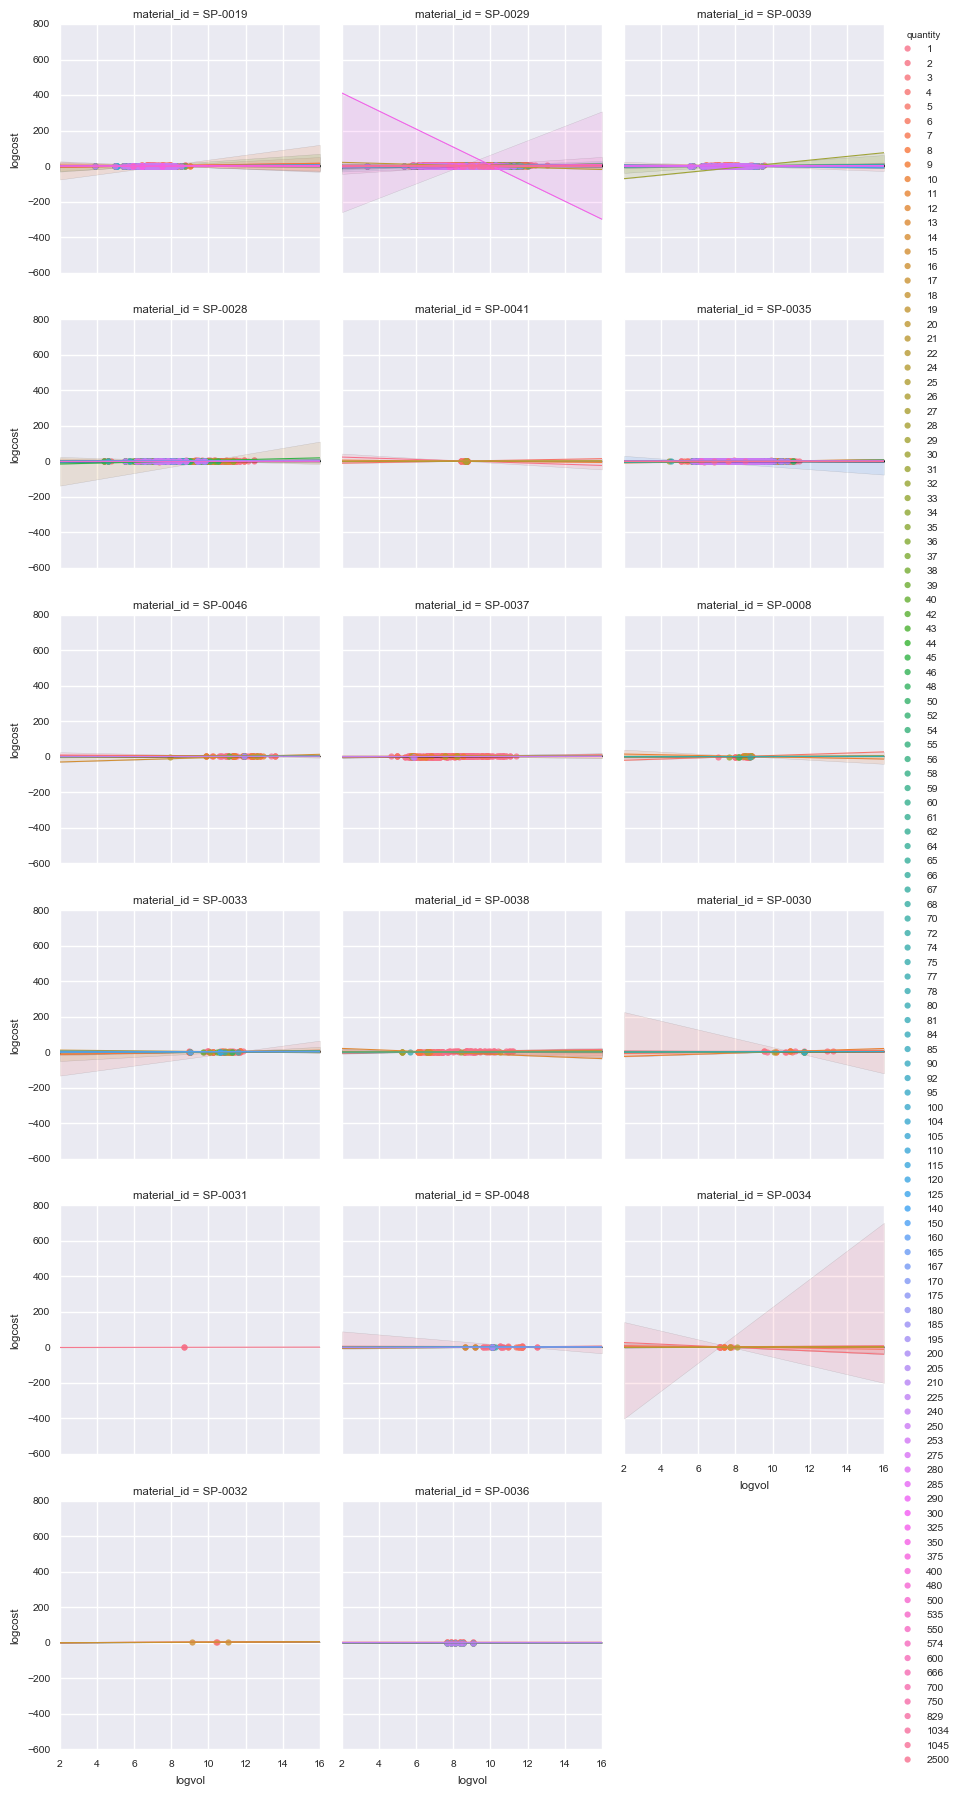

In [148]:
g = sns.lmplot(x = "logvol", y = "logcost", hue = "quantity", col = "material_id", data = df_new, col_wrap = 3, size = 3)

### Heatmap - Correlation Matrix

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5,  22.5]),
 <a list of 23 Text xticklabel objects>)

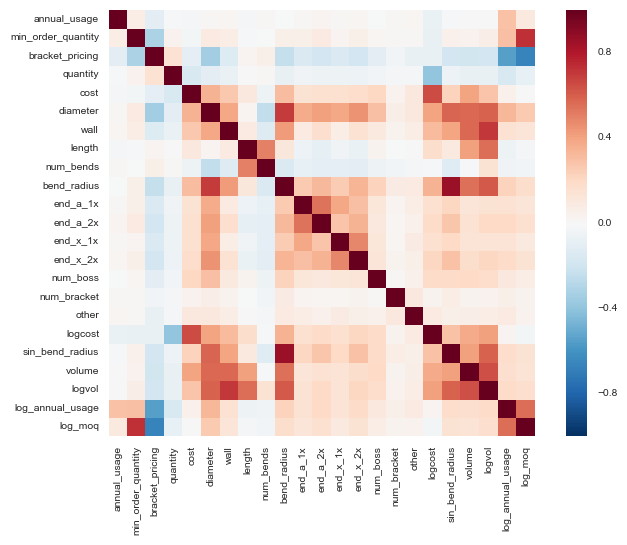

In [77]:
# data set and correlation between the variables after cleaning and formatting it

cm = df_new.corr()
sns.heatmap(cm, square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)

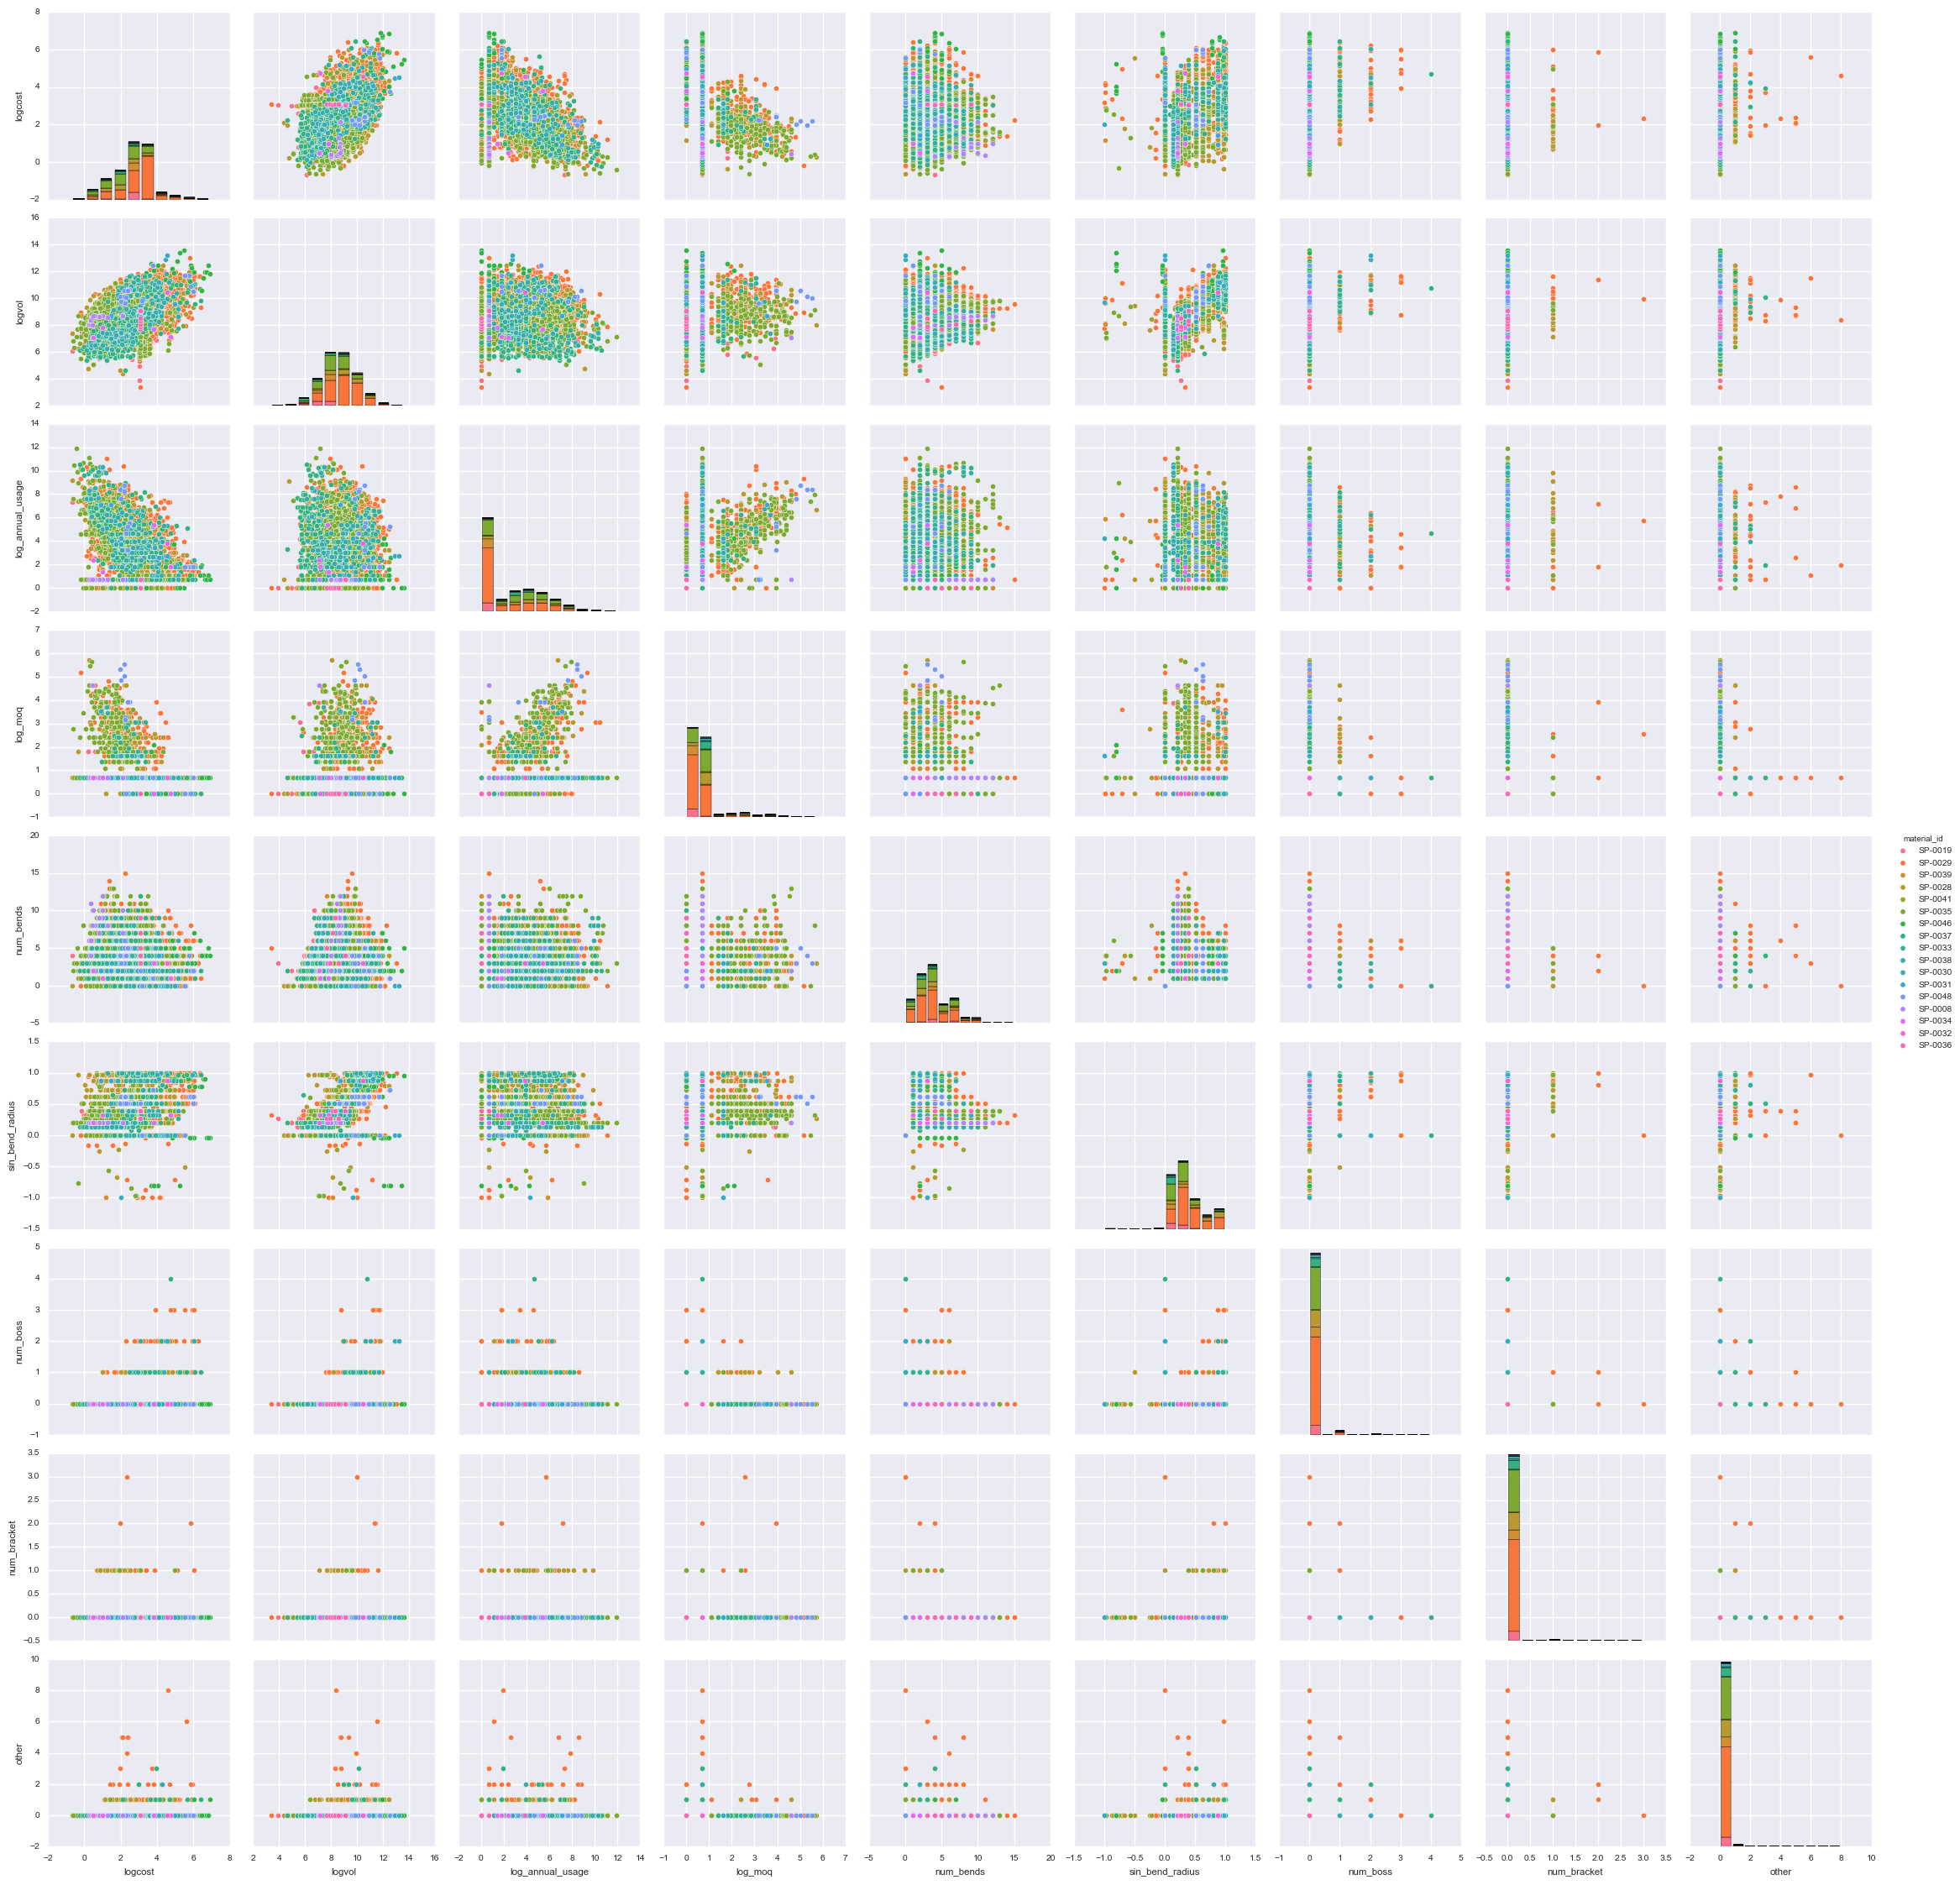

In [78]:
transformed_features = ['logcost', 'logvol', 'log_annual_usage', 'log_moq', 'num_bends', 'sin_bend_radius', 'num_boss', 'num_bracket', 'other', 'material_id']
g = sns.pairplot(df_new[df_new.quantity == 1][transformed_features], hue = 'material_id')

### Variable Selection

In [80]:
selected_features = ['logcost', 'quantity','logvol','log_annual_usage', 'log_moq', 'num_bends', 'sin_bend_radius', 'num_boss', 'num_bracket', 'other']
df_selected = df_new[selected_features]
df_selected.describe()

,logcost,quantity,logvol,log_annual_usage,log_moq,num_bends,sin_bend_radius,num_boss,num_bracket,other
count,30167.000000,30167.000000,30167.000000,30167.000000,30167.000000,30167.000000,30167.000000,30167.000000,30167.000000,30167.000000
mean,2.037891,38.411808,8.424958,1.121780,0.273000,3.814234,0.366004,0.025259,0.003547,0.013492
std,0.923779,70.783022,1.216863,1.918749,0.786436,2.199544,0.204199,0.185029,0.069717,0.150527
min,-0.686067,1.000000,3.370963,0.000000,0.000000,0.000000,-0.999755,0.000000,0.000000,0.000000
25%,1.354651,2.000000,7.555244,0.000000,0.000000,2.000000,0.199105,0.000000,0.000000,0.000000
50%,1.874623,10.000000,8.323847,0.000000,0.000000,3.000000,0.327894,0.000000,0.000000,0.000000
75%,2.596691,40.000000,9.304021,1.098612,0.000000,5.000000,0.509426,0.000000,0.000000,0.000000
max,6.907755,2500.000000,13.587518,11.918397,6.284134,17.000000,0.999464,5.000000,3.000000,8.000000


## PCA

In [81]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca.fit(df_selected)

PCA(copy=True, n_components=2, whiten=False)

In [82]:
pca.components_

array([[ -5.19053693e-03,   9.99975362e-01,  -1.29511373e-03,
         -4.42584877e-03,  -9.06787152e-04,   4.57173578e-04,
         -1.63318768e-04,  -8.81461683e-05,  -1.89796759e-05,
         -4.72643679e-05],
       [ -7.88660611e-03,   8.98457604e-04,  -9.62730156e-02,
          1.30993423e-01,   3.46719322e-02,  -9.85995963e-01,
          9.73422287e-03,   4.44975943e-03,   1.20182199e-03,
          1.74395278e-03]])

In [83]:
X = df_selected.ix[:, df_selected.columns != 'logcost']
Y = df_selected.logcost
#target_names = iris.target_names

pca = PCA(n_components = 2)
X_pca = pca.fit(X).transform(X) # fit data and then transform it

print ('pca:', pca.components_)

('pca:', array([[  9.99988833e-01,  -1.29468841e-03,  -4.42597154e-03,
         -9.06844370e-04,   4.57161931e-04,  -1.63267524e-04,
         -8.81154622e-05,  -1.89778540e-05,  -4.72530495e-05],
       [ -9.40510603e-04,   9.53147201e-02,  -1.30948714e-01,
         -3.46218946e-02,   9.86126820e-01,  -9.84772718e-03,
         -4.50834326e-03,  -1.20592977e-03,  -1.76532025e-03]]))


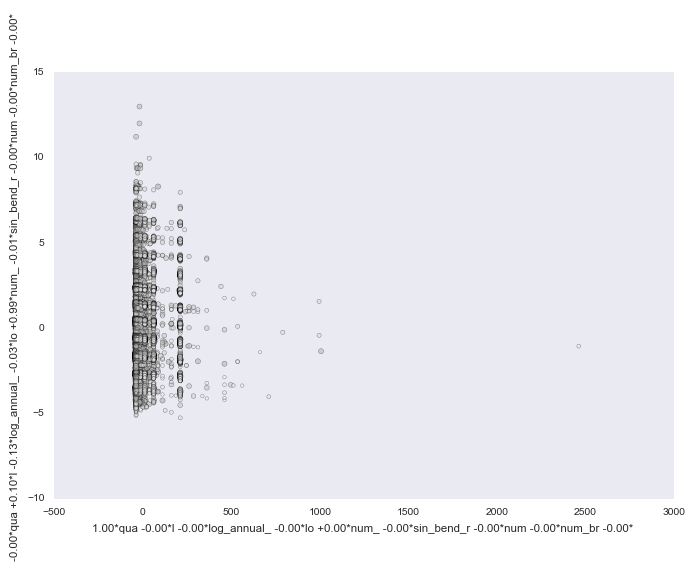

In [84]:
def get_feature_names_from_weights(weights, names):
    tmp_array = []
    for comp in weights:
        tmp_string = ''
        for fidx,f in enumerate(names):
            if fidx>0 and comp[fidx]>=0:
                tmp_string+='+'
            tmp_string += '%.2f*%s ' % (comp[fidx],f[:-5])
        tmp_array.append(tmp_string)
    return tmp_array
  
pca_weight_strings = get_feature_names_from_weights(pca.components_, X) 

df_selected_pca = pd.DataFrame(X_pca,columns=[pca_weight_strings])

from pandas.tools.plotting import scatter_plot

plt.figure(figsize = (16, 16))

ax = scatter_plot(df_selected_pca, pca_weight_strings[0], pca_weight_strings[1], c = Y, s=(Y+2)*3, alpha = 0.5)
newfig = plt.figure()

## Conclusion

As shown in the *interactive* chart (cost vs. quantity) and the PCA first component (value = 9.99988833e-01), the cost of a tube assembly is heavily influenced by the quantity quoted.

The cost curve can be modeled by quantity on an individual basis:
$$cost = a \times e^{-b \times quantity}+c$$

Tube assemblies with unrealistic values (e.g. length = 0 or bend radius > 360 degrees) were dropped. Also, regarding data quality, it seems that some of the quote dates are not reliable (the data ranges from 1982 to 2017).

Logartithmic transformations proved to be very helpful to approximate linear relationships. Similarly the sinus functions was applied to bend radius. Another geometric function applied was the volume of the tube.

Although the number of bends doesn't seem to have a major impact on cost per the boxplot, the second component on the PCA analysis assigns it a high coefficient.

The scatter plots of Log Cost as a function of Log Vol by Material were attempted using matplotlib and Seaborn. Seaborn was significantly easier to use, but the result is highly dubious.

Finally, as shown in the pairplot the following relationships were discovered, cost is
- directly proportional to volume, bend radius, num_boss
- indirectly proportional to annual usage, minimum order quantity

The influence of categorical variables (e.g. Material and Supplier) still need to be considered to develop an accurate model.